In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from libs.InteractivePitchUI import InteractivePitch, PitchDisplay

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 1: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2024GERMANY", "England")
one_match = extract_one_match(data, 4)


In [6]:
print(np.unique(one_match['match_name']))

['Denmark_England' 'England_Slovakia' 'England_Slovenia'
 'England_Switzerland']


In [5]:
import os
import json
import re
import numpy as np
import pandas as pd
from libs.Video_Player import *

def extract_metadata(file_path):
    """Load and return data from a JSON file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_half_start(data):
    """Extract and convert start times of the first and second half into seconds."""
    first_half_start = data["halvesTimestamps"]["1H"]["startTime"]
    second_half_start = data["halvesTimestamps"]["2H"]["startTime"]

    # Convert HH:MM:SS to total seconds
    def time_to_seconds(time_str):
        h, m, s = map(int, time_str.split(":"))
        return h * 3600 + m * 60 + s

    return time_to_seconds(first_half_start), time_to_seconds(second_half_start)

def find_files(match_folder):
    """Finds the .json and .mp4 files in the match folder."""
    json_file, video_file = None, None

    for file in os.listdir(match_folder):
        if file.endswith(".json"):
            json_file = os.path.join(match_folder, file)
        elif file.endswith(".mp4"):
            video_file = os.path.join(match_folder, file)

    if not json_file or not video_file:
        raise FileNotFoundError("Required .json or .mp4 file missing in the folder.")

    return json_file, video_file

def find_match_folder(tournament_folder, match_name):
    """
    Finds the correct match folder inside the tournament folder.
    Match folders contain numbers (e.g., '2036178_Denmark_England'),
    so we search for a folder that contains 'match_name'.
    """
    for folder in os.listdir(tournament_folder):
        if match_name in folder:
            return os.path.join(tournament_folder, folder)
    
    raise FileNotFoundError(f"Match folder for '{match_name}' not found in '{tournament_folder}'")

def process_match_data(tournament_folder, raw_match_name):
    """
    Given the tournament folder and match name from the DataFrame,
    locate the correct match folder, extract halves' start times, and find the video.
    """
    match_folder = find_match_folder(tournament_folder, raw_match_name)
    
    # Find JSON and MP4 files dynamically
    json_file, video_file = find_files(match_folder)

    # Extract data from JSON
    data = extract_metadata(json_file)
    first_half_start, second_half_start = extract_half_start(data)

    return {
        "match_folder": match_folder,
        "json_file": json_file,
        "video_file": video_file,
        "first_half_start": first_half_start,
        "second_half_start": second_half_start
    }

# **Optimized function to process only unique match names**
def process_dataframe(df, tournament_folder):
    """Processes each unique match in the DataFrame to extract JSON and video details."""
    results = []
    
    unique_match_names = df['match_name'].drop_duplicates().tolist()  # Extract unique match names

    for match_name in unique_match_names:
        try:
            match_data = process_match_data(tournament_folder, match_name)
            results.append(match_data)
        except FileNotFoundError as e:
            print(f"Error processing match {match_name}: {e}")
    return pd.DataFrame(results)

# Example usage:
tournament_folder = "data/H_EURO2024GERMANY"

processed_data = process_dataframe(one_match, tournament_folder)

def display_match_info(df):
    """Displays match information in a structured format."""
    if df.empty:
        print("No valid match data found.")
        return

    print("\n=========== Processed Match Data ===========")
    
    for i, row in df.iterrows():
        print(f"\nMatch Folder: {row['match_folder']}")
        print(f"Folder Name: {os.path.basename(row['match_folder'])}\n")

        print(f"JSON File: {row['json_file']}")
        print(f"JSON Name: {os.path.basename(row['json_file'])}\n")

        print(f"Video File: {row['video_file']}")
        print(f"Video Name: {os.path.basename(row['video_file'])}\n")

        print(f"First Half Start: {row['first_half_start']} seconds")
        print(f"Second Half Start: {row['second_half_start']} seconds")
        print("=" * 50)  # Separator line

# Example usage:
display_match_info(processed_data)

# Extracting video details for playback
for _, row in processed_data.iterrows():
    video_file = row["video_file"]
    video_name = os.path.basename(video_file)
    first_half_start = row["first_half_start"]
    second_half_start = row["second_half_start"]
    print(second_half_start)
    example_indices = np.array([[0, '1H'], [0, '2H']])

    # Launch Video Player
    VideoPlayer(video_file, video_name, first_half_start, second_half_start, example_indices)
    


=========== Processed Match Data ===========

Match Folder: data/H_EURO2024GERMANY\2036178_Denmark_England
Folder Name: 2036178_Denmark_England

JSON File: data/H_EURO2024GERMANY\2036178_Denmark_England\DEN - ENG.json
JSON Name: DEN - ENG.json

Video File: data/H_EURO2024GERMANY\2036178_Denmark_England\3-2024-2036178-Denmark_England.mp4
Video Name: 3-2024-2036178-Denmark_England.mp4

First Half Start: 9 seconds
Second Half Start: 3751 seconds

Match Folder: data/H_EURO2024GERMANY\2036189_England_Slovenia
Folder Name: 2036189_England_Slovenia

JSON File: data/H_EURO2024GERMANY\2036189_England_Slovenia\SRB - ENG.json
JSON Name: SRB - ENG.json

Video File: data/H_EURO2024GERMANY\2036189_England_Slovenia\3-2024-2036200-England_Slovakia.mp4
Video Name: 3-2024-2036200-England_Slovakia.mp4

First Half Start: 8 seconds
Second Half Start: 3826 seconds

Match Folder: data/H_EURO2024GERMANY\2036200_England_Slovakia
Folder Name: 2036200_England_Slovakia

JSON File: data/H_EURO2024GERMANY\2036200_

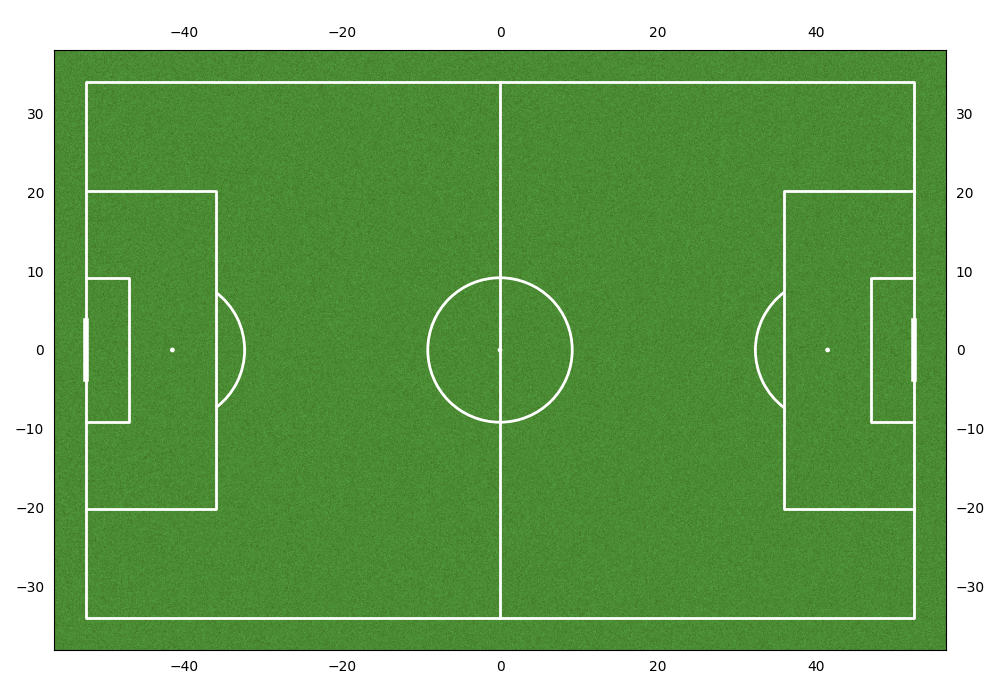

: 

In [ ]:
%matplotlib widget

interactive_pitch = InteractivePitch(one_match)


In [4]:
index_displayer = PitchDisplay(one_match,interactive_pitch.similar_situation_indices)

IndexError: list index out of range

In [8]:
from libs.similar_movement import *


distance_index_list =find_similar_movement_given_vector(one_match, interactive_pitch.vectors[0], interactive_pitch.similar_situation_indices[:100] ) #find_similar_movement(one_match,,interactive_pitch.similar_situation_indices[:100])

In [9]:
print(distance_index_list)

[(4683.239578378611, 218208), (4932.910895329151, 120816), (6136.158273479492, 242064), (5554.688468465564, 57408), (6116.137587674855, 454800), (4484.568295110301, 218256), (5033.9072581535975, 195648), (5538.549552869521, 48480), (6258.710934921566, 132432), (5294.110722503281, 448704), (5761.14283320303, 282720), (5028.57223912088, 38688), (6369.855752147353, 431040), (5709.774811889002, 120768), (4898.592006187432, 48528), (5105.439345079709, 530544), (4450.350708036628, 120864), (3515.542898531442, 309504), (4216.646407409177, 432624), (6554.152826713617, 232464), (5841.977234986971, 158496), (5026.947217479397, 195600), (4270.286454144607, 158544), (4395.938341107871, 442944), (5910.1840857532225, 445488), (1951.2289472664213, 388224), (5400.870864817008, 478512), (2995.7043912304766, 217344), (5547.387807789962, 120672), (5818.583370802528, 120720), (2471.221947899762, 217392), (6696.25295427347, 431376), (2830.4921257762344, 268512), (5771.554079063577, 442992), (5443.210681355

In [10]:
distance_index_list = sorted(distance_index_list, key = lambda x : x[0])

In [11]:
print(len(distance_index_list))

98


In [12]:
index_displayer_2 = PitchDisplay(one_match, [index for (_,index) in distance_index_list])